In [1]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)

In [2]:
files = glob.glob('train/*')

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(12500, 12500)

In [4]:
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [5]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

In [6]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

Using TensorFlow backend.


In [7]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (6000, 150, 150, 3) 	Validation dataset shape: (1951, 150, 150, 3)


(150, 150, 3)


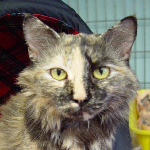

In [8]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [9]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat'] [0 0 0 0 0 0 0 0 0 0]


In [10]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)             0         
__________

In [12]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 6000 samples, validate on 1951 samples
Epoch 1/30
6000/6000 [==============================] - 222s 37ms/step - loss: 0.7142 - acc: 0.6067 - val_loss: 0.6118 - val_acc: 0.6438
Epoch 2/30
6000/6000 [==============================] - 89s 15ms/step - loss: 0.5617 - acc: 0.7123 - val_loss: 0.5404 - val_acc: 0.7201
Epoch 3/30
6000/6000 [==============================] - 90s 15ms/step - loss: 0.4866 - acc: 0.7693 - val_loss: 0.5380 - val_acc: 0.7314
Epoch 4/30
6000/6000 [==============================] - 89s 15ms/step - loss: 0.4027 - acc: 0.8182 - val_loss: 0.4915 - val_acc: 0.7781
Epoch 5/30
6000/6000 [==============================] - 90s 15ms/step - loss: 0.3217 - acc: 0.8613 - val_loss: 0.5215 - val_acc: 0.7858
Epoch 6/30
6000/6000 [==============================] - 89s 15ms/step - loss: 0.2443 - acc: 0.8955 - val_loss: 0.5526 - val_acc: 0.7832
Epoch 7/30
6000/6000 [==============================] - 90s 15ms/step - loss: 0.1665 - acc: 0.9383 - val_loss: 0.5828 - val_acc: 0.7837

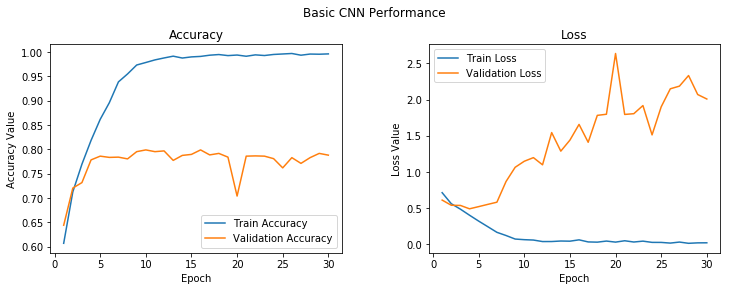

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# CNN Model with Transfer Learning and Data Augmentation

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)


Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


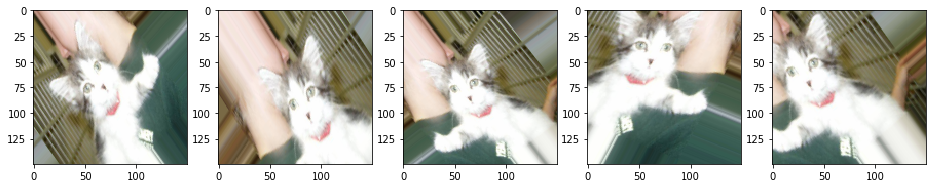

In [16]:
img_id = 2595
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


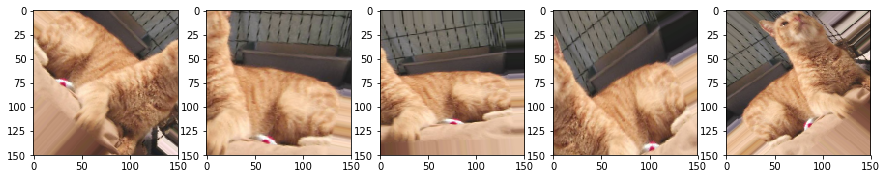

In [17]:
img_id = 1991
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

In [18]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

58892288/58889256 [==============================] - 467s 8us/step


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002742A7A1710>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x000002742AA0C7B8>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000002742AA0CDD8>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x000002742A9F3320>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x000002742A9F35F8>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x000002742A7E8198>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x000002742A9EB550>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x000002742A9EB4E0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x000002742A720E48>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x000002742AA3A400>,block3_conv3,False


In [19]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (6000, 8192) 	Validation Bottleneck Features: (1951, 8192)


In [20]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)

Epoch 1/100
100/100 [==============================] - 154s 2s/step - loss: 0.6616 - acc: 0.6007 - val_loss: 0.4985 - val_acc: 0.8070
Epoch 2/100
100/100 [==============================] - 144s 1s/step - loss: 0.5661 - acc: 0.7077 - val_loss: 0.4205 - val_acc: 0.8254
Epoch 3/100
100/100 [==============================] - 141s 1s/step - loss: 0.5156 - acc: 0.7540 - val_loss: 0.3640 - val_acc: 0.8500
Epoch 4/100
100/100 [==============================] - 141s 1s/step - loss: 0.4745 - acc: 0.7720 - val_loss: 0.3521 - val_acc: 0.8396
Epoch 5/100
100/100 [==============================] - 141s 1s/step - loss: 0.4475 - acc: 0.7903 - val_loss: 0.2938 - val_acc: 0.8660
Epoch 6/100
100/100 [==============================] - 141s 1s/step - loss: 0.4476 - acc: 0.7880 - val_loss: 0.3232 - val_acc: 0.8698
Epoch 7/100
100/100 [==============================] - 141s 1s/step - loss: 0.4247 - acc: 0.7980 - val_loss: 0.3192 - val_acc: 0.8650
Epoch 8/100
100/100 [==============================] - 141s 1s

Epoch 62/100
100/100 [==============================] - 144s 1s/step - loss: 0.3107 - acc: 0.8617 - val_loss: 0.2214 - val_acc: 0.9090
Epoch 63/100
100/100 [==============================] - 144s 1s/step - loss: 0.2976 - acc: 0.8733 - val_loss: 0.2801 - val_acc: 0.8860
Epoch 64/100
100/100 [==============================] - 144s 1s/step - loss: 0.3283 - acc: 0.8560 - val_loss: 0.2617 - val_acc: 0.8940
Epoch 65/100
100/100 [==============================] - 144s 1s/step - loss: 0.3219 - acc: 0.8613 - val_loss: 0.2105 - val_acc: 0.9203
Epoch 66/100
100/100 [==============================] - 144s 1s/step - loss: 0.3136 - acc: 0.8583 - val_loss: 0.2622 - val_acc: 0.8930
Epoch 67/100
100/100 [==============================] - 144s 1s/step - loss: 0.3155 - acc: 0.8673 - val_loss: 0.2686 - val_acc: 0.8880
Epoch 68/100
100/100 [==============================] - 144s 1s/step - loss: 0.3133 - acc: 0.8677 - val_loss: 0.2329 - val_acc: 0.9120
Epoch 69/100
100/100 [==============================] -

In [21]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])       

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002742A7A1710>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x000002742AA0C7B8>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000002742AA0CDD8>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x000002742A9F3320>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x000002742A9F35F8>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x000002742A7E8198>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x000002742A9EB550>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x000002742A9EB4E0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x000002742A720E48>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x000002742AA3A400>,block3_conv3,False


In [22]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)

Epoch 1/100
100/100 [==============================] - 212s 2s/step - loss: 0.6130 - acc: 0.6560 - val_loss: 0.3842 - val_acc: 0.8370
Epoch 2/100
100/100 [==============================] - 210s 2s/step - loss: 0.4091 - acc: 0.8207 - val_loss: 0.2044 - val_acc: 0.9173
Epoch 3/100
100/100 [==============================] - 210s 2s/step - loss: 0.3370 - acc: 0.8567 - val_loss: 0.2368 - val_acc: 0.9050
Epoch 4/100
100/100 [==============================] - 210s 2s/step - loss: 0.3045 - acc: 0.8750 - val_loss: 0.2290 - val_acc: 0.9162
Epoch 5/100
100/100 [==============================] - 210s 2s/step - loss: 0.2662 - acc: 0.8933 - val_loss: 0.1659 - val_acc: 0.9340
Epoch 6/100
100/100 [==============================] - 210s 2s/step - loss: 0.2524 - acc: 0.8920 - val_loss: 0.1780 - val_acc: 0.9354
Epoch 7/100
100/100 [==============================] - 210s 2s/step - loss: 0.2252 - acc: 0.9090 - val_loss: 0.1587 - val_acc: 0.9380
Epoch 8/100
100/100 [==============================] - 210s 2s

Epoch 62/100
100/100 [==============================] - 217s 2s/step - loss: 0.0534 - acc: 0.9827 - val_loss: 0.1592 - val_acc: 0.9640
Epoch 63/100
100/100 [==============================] - 217s 2s/step - loss: 0.0642 - acc: 0.9773 - val_loss: 0.1598 - val_acc: 0.9707
Epoch 64/100
100/100 [==============================] - 217s 2s/step - loss: 0.0587 - acc: 0.9767 - val_loss: 0.1488 - val_acc: 0.9670
Epoch 65/100
100/100 [==============================] - 217s 2s/step - loss: 0.0533 - acc: 0.9797 - val_loss: 0.2660 - val_acc: 0.9364
Epoch 66/100
100/100 [==============================] - 217s 2s/step - loss: 0.0546 - acc: 0.9830 - val_loss: 0.1249 - val_acc: 0.9730
Epoch 67/100
100/100 [==============================] - 217s 2s/step - loss: 0.0533 - acc: 0.9820 - val_loss: 0.1245 - val_acc: 0.9748
Epoch 68/100
100/100 [==============================] - 218s 2s/step - loss: 0.0518 - acc: 0.9807 - val_loss: 0.1216 - val_acc: 0.9740
Epoch 69/100
100/100 [==============================] -

In [23]:
model.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

In [25]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
%matplotlib inline

# load saved models
tl_img_aug_finetune_cnn = load_model('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

# load other configurations
IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]

# load VGG model for bottleneck features
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [27]:
 IMG_DIM = (150, 150)

test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255
test_labels_enc = class2num_label_transformer(test_labels)

print('Test dataset shape:', test_imgs.shape)
print(test_labels[0:5], test_labels_enc[0:5])

Test dataset shape: (1954, 150, 150, 3)
['cat', 'cat', 'cat', 'cat', 'cat'] [0, 0, 0, 0, 0]


In [28]:
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

NameError: name 'meu' is not defined

In [29]:
predictions

['cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'dog',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'dog',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'dog',
 'cat',
 'cat',
 'cat',
 'dog',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'dog',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',


In [ ]:
meu.plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled, 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1])

In [ ]:
print("Hello world")